# Create Geographic information datasets about hotels and accommodations in Andorra

**Please note that Open Street Map data is not at all complete**, this content is for a demonstration.

We retrieve data from OSM (using the [overpass API](http://overpass-api.de)) and from [simplemaps](https://simplemaps.com/gis/country/ad) to get the boundaries of Andorra's parishes (the name of their administrative divisions). 

We generate two files:

* A file with all the touristic accommodations in Andorra, with geographic information about them.
* A file with information about accommodation by parish.

In [1]:
import requests
import pandas as pd
import geopandas as gpd
import folium
from folium.plugins import MarkerCluster
import plotly.express as px

## Step 1: Get data from OSM for Andorran accommodations

In [2]:
def get_accommodations(country):
    """
    Retrieves hostels, hotels, and motels from OpenStreetMap for Andorra using Overpass.
    Returns a pandas DataFrame containing their attributes, latitude, and longitude.
    """
    overpass_url = "http://overpass-api.de/api/interpreter"

    overpass_query = f"""
            [out:json];
        area["name"="{country}"]; // Find the area corresponding to the city name
        (
          node["tourism"~"^(hostel|hotel|motel|guesthouse|bed_and_breakfast|apartment|vacation_rental)$"](area);
            );
        out body;
        """

    response = requests.get(overpass_url, params={'data': overpass_query})
    response.raise_for_status()
    data = response.json()

    # Parse the response and structure it into a DataFrame
    elements = data.get('elements', [])
    accommodations = []

    for element in elements:
        accommodation = {
            "id": element.get("id"),
            "name": element.get("tags", {}).get("name", "Unknown"),
            "type": element.get("tags", {}).get("tourism"),
            "latitude": element.get("lat"),
            "longitude": element.get("lon"),
            "street": element.get("tags", {}).get("addr:street", "Unknown"),
            "post_code": element.get("tags", {}).get("addr:postcode", "Unknown"),
            "city": element.get("tags", {}).get("addr:city", "Unknown"),
            "website": element.get("tags", {}).get("website", "N/A"),
        }
        accommodations.append(accommodation)

    df = pd.DataFrame(accommodations)
    return df

In [3]:
def make_gdf(df):
    """
    Converts a DataFrame with latitude and longitude columns into a GeoDataFrame.
    Assumes columns 'latitude' and 'longitude' exist in the DataFrame.
    """
    # Check if DataFrame contains the required columns
    if 'latitude' not in df.columns or 'longitude' not in df.columns:
        raise ValueError("DataFrame must contain 'latitude' and 'longitude' columns.")
    
    # Create a GeoDataFrame
    gdf = gpd.GeoDataFrame(
        df,
        geometry=gpd.points_from_xy(df['longitude'], df['latitude']),
        crs="EPSG:4326"  # WGS 84 coordinate system for OSM data
    )
    return gdf

In [4]:
df_accommodations = get_accommodations("Andorra")
df_accommodations.head(2)

,id,name,type,latitude,longitude,street,post_code,city,website
0,268096174,Hotel Xalet Besoli,hotel,42.568492,1.489601,Unknown,Unknown,Unknown,https://xaletbesoli.top/
1,278752636,Hotel Nordic,hotel,42.577684,1.650679,Unknown,Unknown,Unknown,N/A


In [5]:
# Convert to GeoDataFrame
gdf_accommodations = make_gdf(df_accommodations)
gdf_accommodations.head(2)

,id,name,type,latitude,longitude,street,post_code,city,website,geometry
0,268096174,Hotel Xalet Besoli,hotel,42.568492,1.489601,Unknown,Unknown,Unknown,https://xaletbesoli.top/,POINT (1.4896 42.56849)
1,278752636,Hotel Nordic,hotel,42.577684,1.650679,Unknown,Unknown,Unknown,N/A,POINT (1.65068 42.57768)


## Step 2: Get data about Andorran borders

In [6]:
# Manually download the GeoJson from: https://simplemaps.com/gis/country/ad
gdf_andorran_borders = gpd.read_file('./andorra.json')

In [7]:
gdf_andorran_borders['name'] = gdf_andorran_borders['name'].replace({
    'Sant Julià de Lòria': 'Sant Julia de Loria'
})

In [8]:
gdf_andorran_borders = gdf_andorran_borders.rename(columns={'name': 'parish'})

In [9]:
gdf_andorran_borders

,source,id,parish,geometry
0,https://simplemaps.com,AD05,Ordino,"POLYGON ((1.45141 42.60205, 1.46681 42.64146, ..."
1,https://simplemaps.com,AD02,Canillo,"POLYGON ((1.55561 42.56265, 1.55784 42.57455, ..."
2,https://simplemaps.com,AD03,Encamp,"POLYGON ((1.55561 42.56265, 1.57122 42.56414, ..."
3,https://simplemaps.com,AD04,La Massana,"POLYGON ((1.45141 42.60205, 1.45968 42.59686, ..."
4,https://simplemaps.com,AD06,Sant Julia de Loria,"POLYGON ((1.44997 42.50407, 1.45968 42.50985, ..."
5,https://simplemaps.com,AD08,Escaldes-Engordany,"POLYGON ((1.55635 42.53811, 1.56899 42.53886, ..."
6,https://simplemaps.com,AD07,Andorra la Vella,"POLYGON ((1.48719 42.51804, 1.50281 42.52473, ..."


## Step 3: Melt GeoDataFrames

In [10]:
gdf_accommodations_with_parish = gpd.sjoin(
    gdf_accommodations, gdf_andorran_borders[['parish', 'geometry']],
    how='inner',  # remove points from outside parishes (not from Andorra the country)
    predicate='within'  # Match points that are within the polygons
)
gdf_accommodations_with_parish = gdf_accommodations_with_parish.drop(columns=['index_right'])
gdf_accommodations_with_parish = gdf_accommodations_with_parish.dropna(subset=['parish'])

In [11]:
gdf_accommodations_with_parish.sample(5)

,id,name,type,latitude,longitude,street,post_code,city,website,geometry,parish
62,3928793752,Roc del Castell,hotel,42.567603,1.601510,Unknown,Unknown,Unknown,N/A,POINT (1.60151 42.5676),Canillo
63,3940604187,Confort,hotel,42.559386,1.686262,Unknown,Unknown,Unknown,N/A,POINT (1.68626 42.55939),Encamp
3,442881217,Hotel Magic Ski,hotel,42.547604,1.513549,Avinguda del Ravell,AD400,La Massana,https://www.hotelmagicski.com/,POINT (1.51355 42.5476),La Massana
57,3870497793,Metropolis,hotel,42.510281,1.540774,Avinguda de les Escoles,Unknown,Unknown,https://www.hotel-metropolis.com/,POINT (1.54077 42.51028),Escaldes-Engordany
12,590463663,Hotel Yomo Patagonia,hotel,42.577688,1.478826,Unknown,Unknown,Unknown,https://www.yomohotels.com/en/hotels/patagonia/,POINT (1.47883 42.57769),La Massana


In [12]:
gdf_accommodations["type"].unique()

array(['hotel', 'apartment', 'hostel'], dtype=object)

In [13]:
gdf_accommodations["hotel"] = gdf_accommodations["type"]=="hotel"
gdf_accommodations["apartment"] = gdf_accommodations["type"]=="apartment"
gdf_accommodations["hostel"] = gdf_accommodations["type"]=="hostel"

In [14]:
gdf_parish_accommodation_info = gpd.sjoin(
    gdf_andorran_borders[['parish', 'geometry']], gdf_accommodations[["type", "hotel", "apartment", "hostel", "geometry"]],
    how='left',
    predicate='contains'
)

# Group by parish and summarize
gdf_parish_info = gdf_parish_accommodation_info.groupby('parish').agg({
    'type': 'count', 
    'hotel':'sum',
    "apartment": "sum",
    "hostel":"sum",
    'geometry': "first" # we can't aggregate by geometry,  
}).reset_index()


In [15]:
gdf_parish_info = gdf_parish_info.rename(columns={"type":"total"})

In [16]:
gdf_parish_info = gpd.GeoDataFrame(gdf_parish_info, geometry=gdf_parish_info['geometry'], crs=4326)

In [17]:
gdf_parish_info

,parish,total,hotel,apartment,hostel,geometry
0,Andorra la Vella,12,11,0,1,"POLYGON ((1.48719 42.51804, 1.50281 42.52473, ..."
1,Canillo,13,11,1,1,"POLYGON ((1.55561 42.56265, 1.55784 42.57455, ..."
2,Encamp,10,9,1,0,"POLYGON ((1.55561 42.56265, 1.57122 42.56414, ..."
3,Escaldes-Engordany,24,22,1,1,"POLYGON ((1.55635 42.53811, 1.56899 42.53886, ..."
4,La Massana,27,22,4,1,"POLYGON ((1.45141 42.60205, 1.45968 42.59686, ..."
5,Ordino,3,3,0,0,"POLYGON ((1.45141 42.60205, 1.46681 42.64146, ..."
6,Sant Julia de Loria,6,6,0,0,"POLYGON ((1.44997 42.50407, 1.45968 42.50985, ..."


## Save files

In [18]:
gdf_accommodations_with_parish.to_file("../src/data/andorra_accommodations.geojson", driver="GeoJSON")

In [19]:
gdf_parish_info.to_file("../src/data/parish_info.geojson", driver="GeoJSON")

## Plot Accommodation places

In [20]:
def create_accommodations_map(gdf):
    """
    Creates a Folium map with markers for accommodations, differentiated by type.
    """
    # Central point for the map using average of x and y
    if gdf.empty:
        raise ValueError("GeoDataFrame is empty. Cannot create a map.")
    
    center_lat = gdf['latitude'].mean()
    center_lon = gdf['longitude'].mean()
    
    folium_map = folium.Map(location=[center_lat, center_lon], zoom_start=10)
    
    # Group Markers in cluster when the zoom is out
    marker_cluster = MarkerCluster().add_to(folium_map)
    
    # Define marker colors based on accommodation type
    marker_colors = {
        'Andorra la Vella' : "blue",
        'Canillo' : "green", 
        'Encamp' : "red", 
        'Escaldes-Engordany' : "black",
        'La Massana' : "purple", 
        'Ordino' : "pink", 
        'Sant Julia de Loria' : "orange"
    }
    
    # Add markers to the map
    for _, row in gdf.iterrows():
        accom_type = row['type']
        marker_color = marker_colors.get(accom_type, 'gray')  # Default to gray if type is unknown
        
        folium.Marker(
            location=[row['latitude'], row['longitude']],
            popup=f"<b>{row['name']}</b><br>Type: {accom_type}<br>Street: {row['street']}<br>Website: {row['website']}",
            icon=folium.Icon(color=marker_color)
        ).add_to(marker_cluster)
    
    return folium_map

In [21]:
map_accommodations = create_accommodations_map(gdf_accommodations_with_parish)

# create html to visualize it inbrowse:
map_accommodations.save("accommodations_map.html")

map_accommodations

<Axes: >

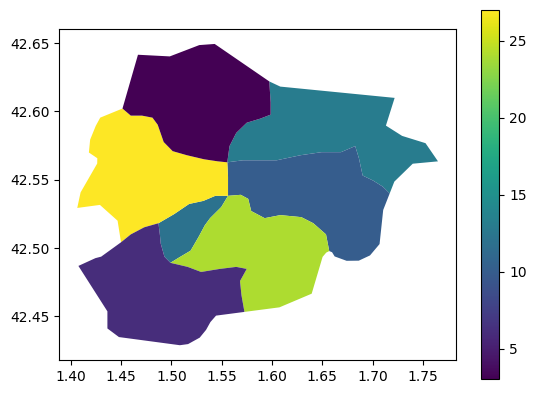

In [22]:
gdf_parish_info.plot(column="total", cmap="viridis", legend=True)

In [23]:
fig = px.choropleth(
    gdf_parish_info,
    locations='parish',
    geojson=gdf_parish_info,
    featureidkey='properties.parish',
    color='total',
    color_continuous_scale="Viridis",
    title="Accommodations in Andorra by Parish"
)

fig.update_geos(fitbounds="locations", visible=False)
fig.update_layout(margin={"r":0,"t":50,"l":0,"b":0})
fig.show()